In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

In [5]:
train_directory = r'C:\Users\darsh\Desktop\hw6\images'
test_directory = r'C:\Users\darsh\Desktop\hw6\test'
image_height = 128
image_width = 128
batch_size = 32
num_classes = 10

In [24]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_directory,
    image_size=(image_height, image_width),
    batch_size=batch_size,
    shuffle=True,
    seed=42
)
class_names = train_dataset.class_names
print(class_names)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_directory,
    image_size=(image_height, image_width),
    batch_size=batch_size
)

Found 1987 files belonging to 10 classes.
['Alfred_Sisley', 'Amedeo_Modigliani', 'Edgar_Degas', 'Pablo_Picasso', 'Paul_Gauguin', 'Pierre-Auguste_Renoir', 'Rembrandt', 'Rene_Magritte', 'Titian', 'Vincent_van_Gogh']
Found 300 files belonging to 10 classes.


In [25]:

train_dataset = train_dataset.map(lambda x, y: (x / 255.0, y))
test_dataset = test_dataset.map(lambda x, y: (x / 255.0, y))


model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(image_height, image_width, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [26]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


history = model.fit(train_dataset, epochs=10, validation_data=test_dataset)


test_loss, test_accuracy = model.evaluate(test_dataset)

print('Test accuracy:', test_accuracy)

Epoch 1/10


C:\Users\darsh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\backend.py:5714: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


63/63 [==============================] - 41s 565ms/step - loss: 2.2967 - accuracy: 0.1958 - val_loss: 1.9003 - val_accuracy: 0.2900
Epoch 2/10
63/63 [==============================] - 34s 512ms/step - loss: 1.7068 - accuracy: 0.3795 - val_loss: 1.6154 - val_accuracy: 0.4167
Epoch 3/10
63/63 [==============================] - 33s 507ms/step - loss: 1.4083 - accuracy: 0.5123 - val_loss: 1.5733 - val_accuracy: 0.4300
Epoch 4/10
63/63 [==============================] - 30s 456ms/step - loss: 1.0939 - accuracy: 0.6306 - val_loss: 1.0226 - val_accuracy: 0.6300
Epoch 5/10
63/63 [==============================] - 21s 331ms/step - loss: 0.7882 - accuracy: 0.7363 - val_loss: 0.7601 - val_accuracy: 0.7500
Epoch 6/10
63/63 [==============================] - 21s 322ms/step - loss: 0.4819 - accuracy: 0.8495 - val_loss: 0.7027 - val_accuracy: 0.7733
Epoch 7/10
63/63 [==============================] - 23s 356ms/step - loss: 0.3113 - accuracy: 0.9064 - val_loss: 0.7812 - val_accuracy: 0.8000
Epoch 8/10

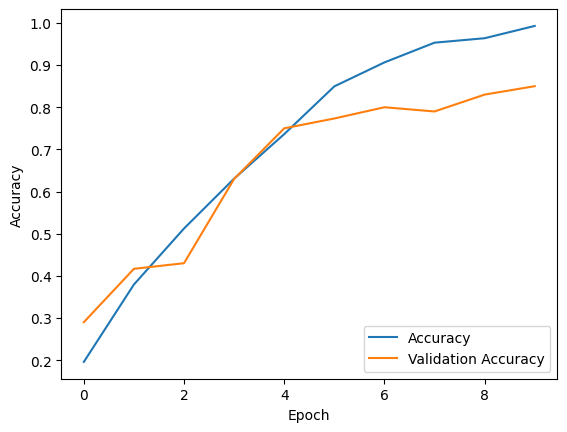

In [27]:
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

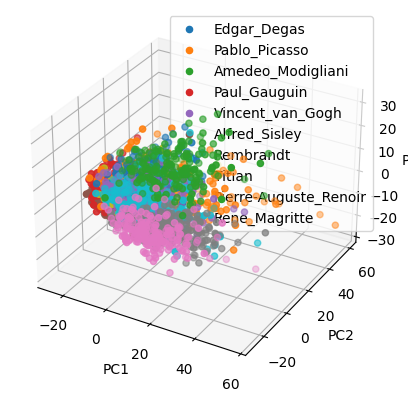

In [28]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

feature_extractor = tf.keras.Model(inputs=model.inputs, outputs=model.layers[-2].output)
train_features = []
train_labels = []

for images, labels in train_dataset:
    features = feature_extractor(images)
    train_features.extend(features)
    train_labels.extend(labels.numpy())

train_features = tf.stack(train_features)
train_labels = tf.stack(train_labels)


pca = PCA(n_components=3)
pca_features = pca.fit_transform(train_features)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for label in tf.unique(train_labels)[0]:
    indices = tf.where(train_labels == label)
    ax.scatter(
        pca_features[indices, 0],
        pca_features[indices, 1],
        pca_features[indices, 2],
        label=class_names[label]
    )

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.legend()
plt.show()


Found 300 files belonging to 10 classes.


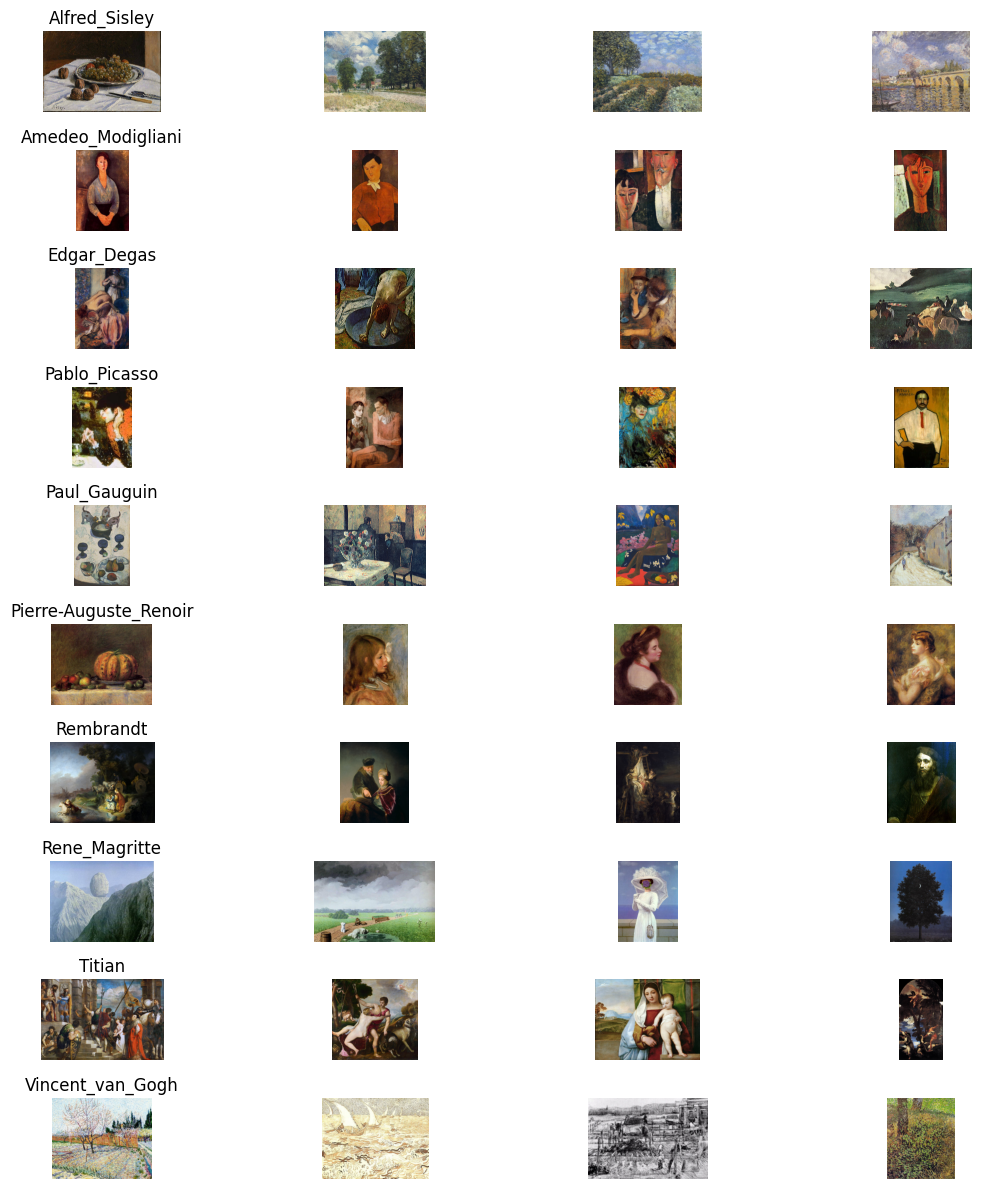

In [30]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_directory,
    image_size=(image_height, image_width),
    batch_size=batch_size,
    shuffle=False
)

test_features = []
test_labels = []

for images, labels in test_ds:
    features = feature_extractor(images)
    test_features.extend(features)
    test_labels.extend(labels.numpy())

test_features = np.array(test_features)
test_labels = np.array(test_labels)

k = 4
closest_indices = []

for label in range(num_classes):
    class_indices = np.where(test_labels == label)[0]
    class_features = test_features[class_indices]
    nn = NearestNeighbors(n_neighbors=k, metric='euclidean')
    nn.fit(class_features)
    _, indices = nn.kneighbors(class_features)
    closest_indices.extend(class_indices[indices[0]])

fig, axs = plt.subplots(num_classes, k, figsize=(12, 12))

for i, index in enumerate(closest_indices):
    img = plt.imread(test_ds.file_paths[index])
    label = test_labels[index]
    axs[label, i % k].imshow(img)
    axs[label, i % k].axis("off")

    if i % k == 0:
        axs[label, 0].set_title(class_names[label])

plt.tight_layout()
plt.show()
